# Load data

In [1]:
# Ajouter le dossier `src` au chemin de recherche Python
import sys
import os
sys.path.append(os.path.abspath('../src'))

# Importer la fonction `load_data` depuis le module `preprocess` dans `data_processing`
from data_processing.preprocessing import *
from utils.plotting import *
from tests_statistics.moments import *
from tests_statistics.jarque_bera import jarque_bera_test
from tests_statistics.ljung_box import ljung_box_test
from tests_statistics.autocorrelation import *
from data_processing.VaR import *

# Spécifier le chemin vers le fichier de données
filepath = '../data/raw/out12.csv'

# Charger les données
data = load_data(filepath)

Aperçu des données chargées :
   day      tick  logprice
0    1  0.002436  4.169607
1    1  0.002479  4.168214
2    1  0.002564  4.168214
3    1  0.003034  4.168214
4    1  0.003590  4.168524


The dataset contains three columns, the first one describing the day, the second column describing a tick between 0 and 1 indicating the time during a trading day. And finally, the third one describing the log price of an asset I guess. 

### Assumption of Data Frequency:
**Time Interval:**

To estimate the time interval between observations, we can divide the total duration of a trading day by the total number of observations. For example, a typical trading day in many markets lasts about 6.5 hours (e.g., from 9:30 AM to 4:00 PM in U.S. markets), which translates to 23,400 seconds.

Thus, the average time interval between observations can be calculated as:

$$
\Delta_t = \frac{23400 \text{ s}}{1638 \text{ obs}} \approx 14.3 \text{ s}
$$

This narrow time interval results in a mean of returns that is very close to zero and a relatively low variance. This low variance makes the returns particularly sensitive to extreme values, which can significantly influence the distributional measures.

Therefore, we will apply a filtering process to our dataset to remove outliers and mitigate this sensitivity to extreme values.

# Step 1. Exploratory data analysis
What information can you extract from your data ? Give an informative summary of your dataset, using appropriate numerical and graphical methods.
## Check Missing values 

In [2]:
# Vérifier les valeurs manquantes
check_missing_values(data)

Valeurs manquantes par colonne :
Series([], dtype: int64)


day         0
tick        0
logprice    0
dtype: int64

## Create the variable compounded_return to compare day by day. 

In [3]:
# Calcul du compounded return 
compounded_return(data, log_price_column = 'logprice', return_column = 'compounded_return')
data.head()

,day,tick,logprice,compounded_return
0,1,0.002436,4.169607,NaN
1,1,0.002479,4.168214,-0.001392
2,1,0.002564,4.168214,0.000000
3,1,0.003034,4.168214,0.000000
4,1,0.003590,4.168524,0.000310


In [4]:
# Supprimer la première ligne
data = data.dropna()
data.head()

,day,tick,logprice,compounded_return
1,1,0.002479,4.168214,-0.001392
2,1,0.002564,4.168214,0.000000
3,1,0.003034,4.168214,0.000000
4,1,0.003590,4.168524,0.000310
5,1,0.003675,4.168060,-0.000464


In [5]:
print(data['compounded_return'].describe())

count    1.615410e+06
mean    -1.364727e-06
std      7.446338e-04
min     -1.762480e-01
25%     -2.584313e-04
50%      0.000000e+00
75%      2.571686e-04
max      1.166369e-01
Name: compounded_return, dtype: float64


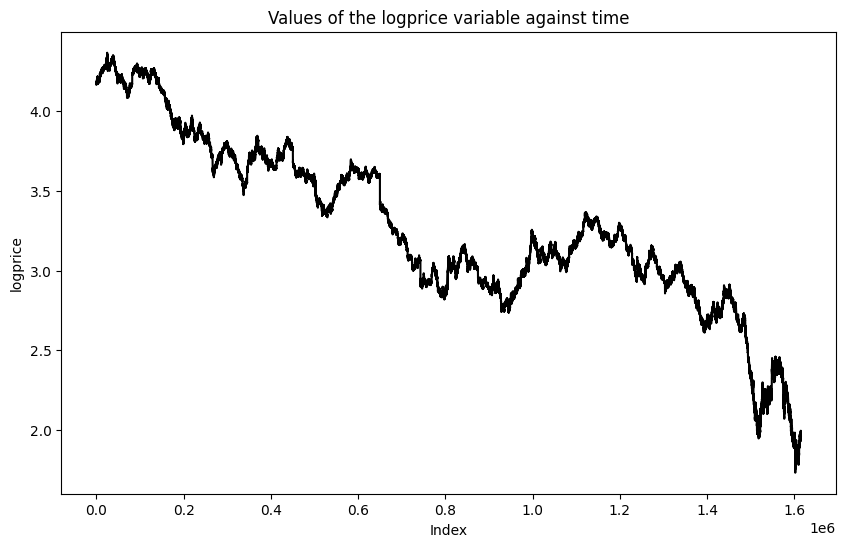

In [6]:
plot_price(data, return_column = 'logprice')

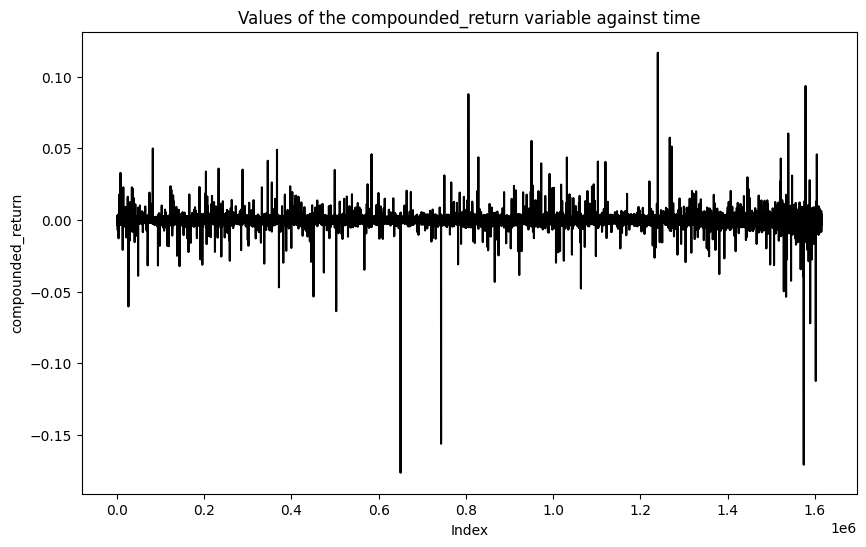

In [7]:
plot_return(data, return_column = 'compounded_return')

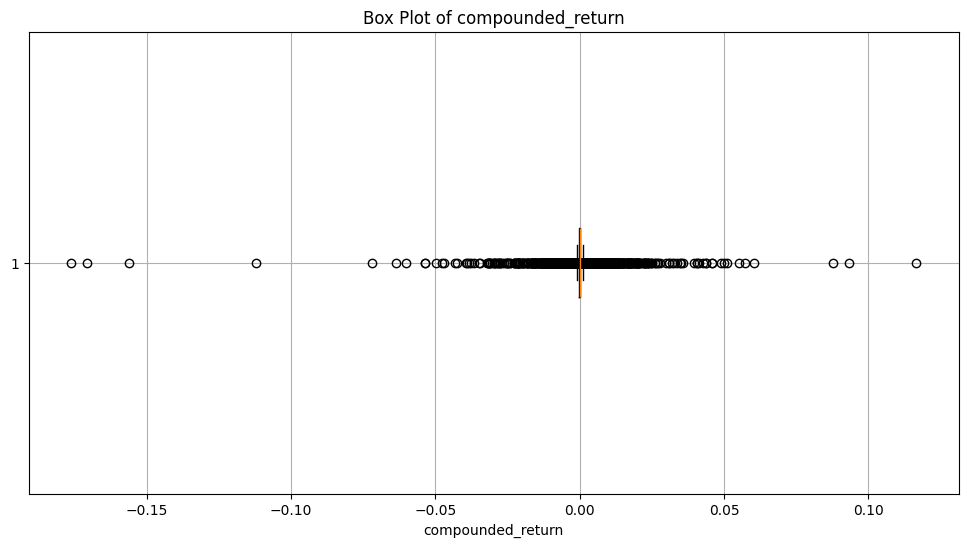

In [8]:
plot_boxplot(data, column = 'compounded_return')

On this boxplot, we observe few outliers. We will need to examine them. 

## Empirical statistics

In [9]:
# Calcul des statistiques
mean_value = empirical_mean(data, 'compounded_return')
variance_value = empirical_variance(data, 'compounded_return')
skewness_value = empirical_skewness(data, 'compounded_return')
kurtosis_value = empirical_kurtosis(data, 'compounded_return')

# Affichage des résultats
print(f"Empirical Mean: {mean_value}")
print(f"Empirical Variance: {variance_value}")
print(f"Empirical Skewness: {skewness_value}")
print(f"Empirical Kurtosis: {kurtosis_value}")

Empirical Mean: -1.364727455647231e-06
Empirical Variance: 5.544791283286485e-07
Empirical Skewness: -19.382784699148104
Empirical Kurtosis: 6307.563527054117


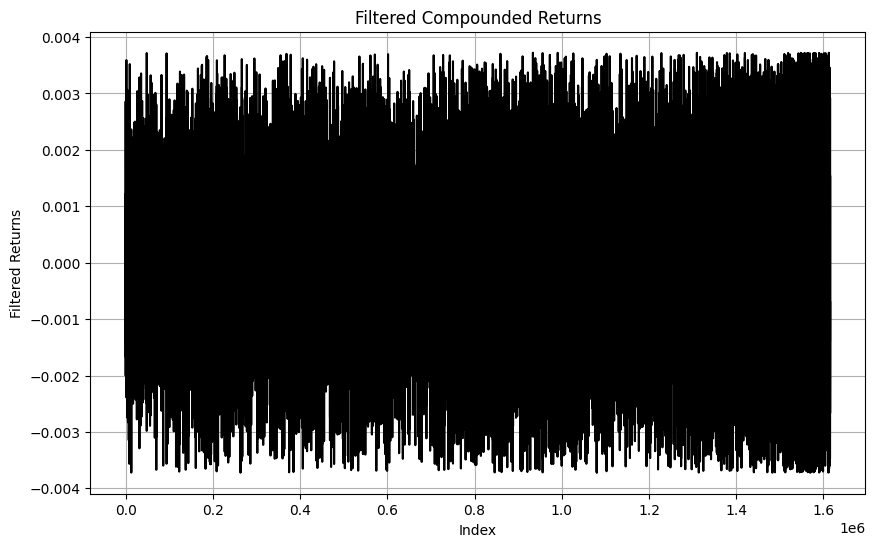

In [10]:
# Filtrer les valeurs aberrantes au-delà de ±5 écarts-types
filtered_data = data[(data['compounded_return'] >= -5 * data['compounded_return'].std()) &
                     (data['compounded_return'] <= 5 * data['compounded_return'].std())]

# Tracer à nouveau
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['compounded_return'], color='black')
plt.title('Filtered Compounded Returns')
plt.xlabel('Index')
plt.ylabel('Filtered Returns')
plt.grid(True)
plt.show()

In [11]:
mean_value = empirical_mean(filtered_data, 'compounded_return')
variance_value = empirical_variance(filtered_data, 'compounded_return')
skewness_value = empirical_skewness(filtered_data, 'compounded_return')
kurtosis_value = empirical_kurtosis(filtered_data, 'compounded_return')

print(f"Empirical Mean (filtered): {mean_value}")
print(f"Empirical Variance (filtered): {variance_value}")
print(f"Empirical Skewness (filtered): {skewness_value}")
print(f"Empirical Kurtosis (filtered): {kurtosis_value}")

Empirical Mean (filtered): -1.4387881804842498e-06
Empirical Variance (filtered): 3.216552702245234e-07
Empirical Skewness (filtered): -0.024444804064610234
Empirical Kurtosis (filtered): 8.369042409767946


These filtered results provide a more robust representation of the compounded_return distribution. The near-zero skewness and high kurtosis confirm that, while the data is generally symmetric, it still exhibits "fat tails," reflecting the presence of rare, significant deviations that are typical in high-frequency financial data. This underscores the importance of accounting for tail risk in financial models, as extreme events remain a key characteristic of the return distribution.

### Jarque-Bera Normality Test

Normality test : 
$$
H_0 : Normal dist., \quad H1 :different from Normal dist. 
$$
Under $H_0, \hat{Skew}, \hat{Kurt}$ are independent and asymptotically normal :
$$
\sqrt{n} \hat{Skew} \rightarrow_d \mathcal{N}(0,6), \quad \sqrt{n} \hat{Kurt}-3  \rightarrow_d \mathcal{N}(0,24)
$$

Jarque-Bera test statistic : Under $H_0$ as $n\rightarrow \infty$,
$$
JB = n \left(\frac{\hat{Skew}^2}{6}+ \frac{(\hat{Kurt}-3)^2}{24}\right)\rightarrow_d \chi^2(2)
$$

In [12]:
# Effectuer le test de Jarque-Bera sur la colonne 'compounded_return'
jb_results = jarque_bera_test(filtered_data, 'compounded_return')

# Afficher les résultats du test
print("Jarque-Bera Test Results:")
print(f"JB Statistic: {jb_results['JB Statistic']}")
print(f"p-value: {jb_results['p-value']}")
print(f"Normality: {jb_results['Normality']}")

Jarque-Bera Test Results:
JB Statistic: 1936497.2259412133
p-value: 0.0
Normality: Rejected


## Volatility
### Volatility based on the mean of a day 

We call daily volatility of the asset, the standard deviation of the log-returns. 

If we observe price on T days, then we can estimate $\sigma_d$ by the square root of the empirical variance. 
$$
\sigma_d^2=\frac{1}{T} \sum_{i=1}^T R_t^2-(\bar R_t)^2
$$
where $\bar R_t = \frac{1}{T} \sum_{i=1}^T R_t$

In [13]:
# Calculer les moyennes journalières des rendements
daily_mean_returns = calculate_daily_mean_returns(filtered_data, day_column='day', return_column='compounded_return')
    
# Enregistrer les moyennes journalières dans le dossier processed
daily_mean_returns.to_csv('../data/processed/daily_mean_returns.csv', index=False)

print("Daily mean returns saved to 'data/processed/daily_mean_returns.csv'.")

Daily mean returns saved to 'data/processed/daily_mean_returns.csv'.


In [14]:
daily_mean_returns.describe()

,day,daily_mean_return
count,754.000000,754.000000
mean,377.500000,-0.000002
std,217.805341,0.000015
min,1.000000,-0.000067
25%,189.250000,-0.000010
50%,377.500000,-0.000002
75%,565.750000,0.000007
max,754.000000,0.000070


In [15]:
# Calculer les volatilités journalière, mensuelle et annualisée
volatility_results = calculate_volatility(daily_mean_returns, return_column='daily_mean_return')

# Afficher les résultats de volatilité
print("Volatility Results:")
print(f"Daily Volatility: {volatility_results['daily_volatility']}")
print(f"Monthly Volatility: {volatility_results['monthly_volatility']}")
print(f"Annualized Volatility: {volatility_results['annualized_volatility']}")

Volatility Results:
Daily Volatility: 1.4577684889564671e-05
Monthly Volatility: 6.680334446364407e-05
Annualized Volatility: 0.0002314135734531132


### Volatility based on the Realized variance 

https://papyrus.bib.umontreal.ca/xmlui/bitstream/handle/1866/2610/a1.1%20g%201120.pdf?sequence=1&isAllowed=y 

In [19]:
# Calculate squared returns
daily_data = filtered_data[filtered_data['compounded_return'].notna()]
daily_data.loc[:, 'squared_return'] = daily_data['compounded_return'] ** 2

# Group by day and compute realized volatility
realized_volatility = daily_data.groupby('day')['squared_return'].sum().apply(np.sqrt)

# Create the daily_data DataFrame with realized_volatility
daily_data_result = realized_volatility.reset_index()
daily_data_result.columns = ['day', 'realized_volatility']

daily_data_result.describe()

,day,realized_volatility
count,754.000000,754.000000
mean,377.500000,0.024926
std,217.805341,0.008155
min,1.000000,0.011805
25%,189.250000,0.019663
50%,377.500000,0.022816
75%,565.750000,0.027760
max,754.000000,0.077253


In [17]:
# Calculer les volatilités journalière, mensuelle et annualisée
volatility_results = calculate_volatility(daily_data_result, return_column='realized_volatility')

# Afficher les résultats de volatilité
print("Volatility Results:")
print(f"Daily Volatility: {volatility_results['daily_volatility']}")
print(f"Monthly Volatility: {volatility_results['monthly_volatility']}")
print(f"Annualized Volatility: {volatility_results['annualized_volatility']}")

Volatility Results:
Daily Volatility: 0.00815511584163732
Monthly Volatility: 0.03737143564543652
Annualized Volatility: 0.1294584505793733


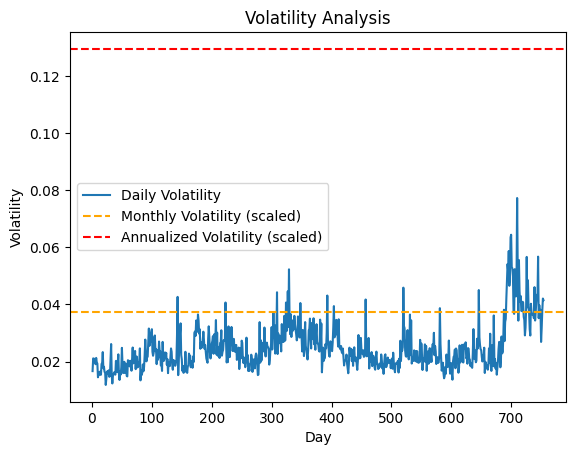

In [ ]:
import matplotlib.pyplot as plt

plt.plot(daily_data_result['day'], daily_data_result['realized_volatility'], label='Daily Volatility')
plt.axhline(y=volatility_results['monthly_volatility'], color='orange', linestyle='--', label='Monthly Volatility (scaled)')
plt.axhline(y=volatility_results['annualized_volatility'], color='red', linestyle='--', label='Annualized Volatility (scaled)')
plt.title('Volatility Analysis')
plt.xlabel('Day')
plt.ylabel('Volatility')
plt.legend()
plt.show()

### Analysis of Results
**Daily Volatility**: 0.0082

A daily volatility of approximately 0.82% indicates the average day-to-day percentage fluctuation in returns.
This value reflects a relatively moderate level of intraday variation, which could be typical for assets like stocks or ETFs in stable market conditions.
Monthly Volatility: 0.0374

A monthly volatility of ~3.74% is consistent with a scaled-up daily volatility using 
21 (assuming 21 trading days in a month).
This value aligns well with expectations for monthly movements, showing that your calculation is accurate.

**Annualized Volatility**: 0.1295

An annualized volatility of ~12.95% suggests moderate variability for the asset over a year.
This level of annual volatility is typical for stable financial instruments like large-cap stocks, indices, or diversified portfolios.

### Comparative Insights

**Benchmarking**:

Equities: Average annual volatility for stock indices (e.g., S&P 500) typically ranges from 15-20% under normal conditions. Your 12.95% suggests a slightly lower-risk profile, possibly for less volatile assets.

Bonds: Bond markets usually exhibit annual volatilities in the range of 5-10%, so your value might represent a slightly riskier instrument if it's related to fixed-income securities.

**Timeframe Analysis**:

If this is derived from a relatively stable market period, these values are reasonable. In times of high market stress (e.g., crises), these numbers might spike significantly.

**Risk-Adjusted Returns**:

These volatility levels can be compared against the average return for the asset to compute metrics like the Sharpe Ratio, which evaluates performance relative to risk.

# Step 2. Analysis of daily time series and VaR (choose one)
Extract the daily closing price to define a daily time series returns data. Use these to estimate VaR.

1. VaR under IID (chosen for this project)
2. VaR under non-stationary time series

Formulate the model and use appropriate hypothesis to compute VaR. Assess whether your hypothesis
is supported by the dataset and suggest any modification to improve your results.

## Extract the daily closing price

In [20]:
# Extract the last logprice for each day
daily_closing_prices = filtered_data.groupby('day').last()['logprice']

# Convert to a DataFrame
daily_closing_prices = daily_closing_prices.reset_index()
daily_closing_prices.columns = ['day', 'logprice']

print(daily_closing_prices)

     day  logprice
0      1  4.187683
1      2  4.201703
2      3  4.194793
3      4  4.198855
4      5  4.192076
..   ...       ...
749  750  1.803359
750  751  1.843719
751  752  1.890095
752  753  1.928619
753  754  1.965012

[754 rows x 2 columns]


## Compute the log returns  from the daily closing price

In [21]:
# Compute daily returns from the closing prices
daily_closing_prices['daily_return'] = daily_closing_prices['logprice'].diff()

# Drop the first row as it will have a NaN value for the return
daily_closing_prices = daily_closing_prices.dropna()

In [26]:
daily_closing_prices['daily_return'].describe()

count    753.000000
mean      -0.002952
std        0.036372
min       -0.224370
25%       -0.022280
50%       -0.003790
75%        0.016698
max        0.202542
Name: daily_return, dtype: float64

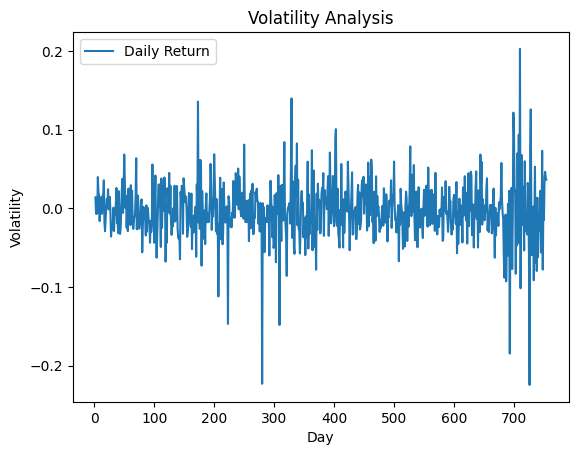

In [22]:
# Assuming `realized_volatility` contains daily volatility
plt.plot(daily_closing_prices['day'], daily_closing_prices['daily_return'], label='Daily Return')
plt.title('Volatility Analysis')
plt.xlabel('Day')
plt.ylabel('Volatility')
plt.legend()
plt.show()

1. Investigating Dividend Events

    Dividends affect stock prices directly because, on the ex-dividend date, the stock price usually drops by the dividend amount. This can create large negative returns on the ex-dividend date.

    **Steps to Check**:

    Identify Dividend Dates: Check if the asset paid dividends on or around the dates of the large negative spikes.

    Compare with Ex-Dividend Returns: If the return spike aligns with a known dividend date, it likely corresponds to the dividend.

2. Investigating Stock Splits or Mergers

    Positive spikes could correspond to stock splits, merger announcements, or other positive events.

    **Steps to Check**:

    Look for corporate announcements around the spike dates.

    Stock splits typically result in adjustments to the price, leading to a temporary misrepresentation in returns.

## Check spike index

In [25]:
# Identify indices where log returns are greater than 0.2 or less than -0.2
spike_indices = daily_closing_prices[
    (daily_closing_prices['daily_return'] > 0.2) | 
    (daily_closing_prices['daily_return'] < -0.2)
].index

# Display the rows with these spikes
spike_data = daily_closing_prices.loc[spike_indices]
print(spike_data)

     day  logprice  daily_return
279  280  3.377246     -0.222939
709  710  2.423917      0.202542
725  726  2.098018     -0.224370


### Possible Explanations for These Spikes:
1. Corporate Events:

    The large negative returns on Day 280 and Day 726 might correspond to ex-dividend dates where the stock price drops after dividend payouts.
    The positive spike on Day 710 could correspond to good news, such as strong earnings or a merger announcement.

2. Market Volatility:

    These spikes could also result from broader market events, like a financial crisis or macroeconomic news affecting the asset.


### Manage the spikes

In [37]:
# Ensure that the daily_return are in a certain range
daily_closing_prices['winsorized_return'] = daily_closing_prices['daily_return'].clip(
    lower=daily_closing_prices['daily_return'].quantile(0.01),
    upper=daily_closing_prices['daily_return'].quantile(0.99)
)
print(daily_closing_prices['winsorized_return'])

1      0.014020
2     -0.006910
3      0.004062
4     -0.006779
5      0.039709
         ...   
749   -0.014718
750    0.040361
751    0.046376
752    0.038523
753    0.036394
Name: winsorized_return, Length: 753, dtype: float64


## Assumptions on the returns

The assumptions on the returns are that : 
- returns follow a normal distribution
- returns are independent over time
- the distribution of the returns does not change over time

We are going to check all these assumptions before computing the VaR. 
As seen before, the compounded return does not follow the normal distribution. We will try the Jarque Bera test to check if the daily mean returns follows the normal distribution. 

### Empirical statistics

In [38]:
# Calcul des statistiques
daily_mean_value = empirical_mean(daily_closing_prices, 'winsorized_return')
daily_variance_value = empirical_variance(daily_closing_prices, 'winsorized_return')
daily_skewness_value = empirical_skewness(daily_closing_prices, 'winsorized_return')
daily_kurtosis_value = empirical_kurtosis(daily_closing_prices, 'winsorized_return')

# Affichage des résultats
print(f"Empirical Mean: {daily_mean_value}")
print(f"Empirical Variance: {daily_variance_value}")
print(f"Empirical Skewness: {daily_skewness_value}")
print(f"Empirical Kurtosis: {daily_kurtosis_value}")

Empirical Mean: -0.0026854439567684605
Empirical Variance: 0.0010382494220797255
Empirical Skewness: 0.10017609953937129
Empirical Kurtosis: 3.6558485658729856


### Check normal distribution using jarque Bera test

In [39]:
# Effectuer le test de Jarque-Bera sur la colonne 'compounded_return'
daily_jb_results = jarque_bera_test(daily_closing_prices, 'winsorized_return')

# Afficher les résultats du test
print("Jarque-Bera Test Results:")
print(f"JB Statistic: {daily_jb_results['JB Statistic']}")
print(f"p-value: {daily_jb_results['p-value']}")
print(f"Normality: {daily_jb_results['Normality']}")

Jarque-Bera Test Results:
JB Statistic: 14.754983075421041
p-value: 0.0006251671289150273
Normality: Rejected


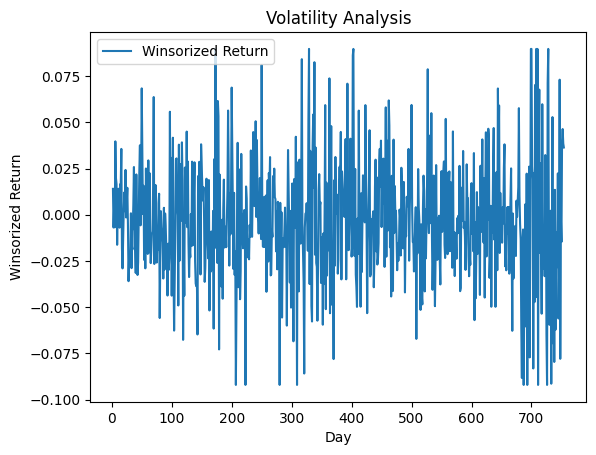

In [40]:
# Assuming `realized_volatility` contains daily volatility
plt.plot(daily_closing_prices['day'], daily_closing_prices['winsorized_return'], label='Winsorized Return')
plt.title('Volatility Analysis')
plt.xlabel('Day')
plt.ylabel('Winsorized Return')
plt.legend()
plt.show()